# Visual Behavior Ophys Experiment Data

This notebook shows how to load optical physiology and behavior data for one imaging plane from one Visual Behavior Ophys session using the AllenSDK. It describes the type of data available and shows a few simple ways of plotting calcium fluorescence traces along with the animal's behavior and stimulus presentation times. 

Before you run this notebook, please install the allenSDK into your environment

### Import required libraries

We need to import libraries for plotting and manipulating data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib notebook
%matplotlib inline

In [2]:
# Import allenSDK and check the version, which should be >2.10.2
import allensdk
allensdk.__version__

'2.15.1'

In [3]:
# import the behavior ophys project cache class from SDK to be able to load the data
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the cache and get metadata tables

In [4]:
# Set the path to the dataset
# cache_dir = r'/Users/marinag/Documents/Data/VisualBehavior/'
cache_dir = '/data/'

In [5]:
# If you are working with data in the cloud in Code Ocean, 
# or if you have already downloaded the full dataset to your local machine, 
# you can instantiate a local cache
cache = VisualBehaviorOphysProjectCache.from_local_cache(cache_dir=cache_dir, use_static_cache=True)

# If you are working with the data locally for the first time, you need to instantiate the cache from S3:
# cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=cache_dir)
          

In [6]:
# get metadata tables
behavior_session_table = cache.get_behavior_session_table()  
ophys_session_table = cache.get_ophys_session_table()   
ophys_experiment_table = cache.get_ophys_experiment_table()                         

#print number of items in each table for all imaging and behavioral sessions
print('Number of behavior sessions = {}'.format(len(behavior_session_table)))
print('Number of ophys sessions = {}'.format(len(ophys_session_table)))
print('Number of ophys experiments = {}'.format(len(ophys_experiment_table)))

Number of behavior sessions = 4787
Number of ophys sessions = 705
Number of ophys experiments = 1941


The term <b>ophys experiment</b> is used to describe one imaging plane during one <b>ophys session</b>. Each ophys session can contain one or more ophys experiments (imaging planes) depending on which microscope was used.

For datasets acquired using a single-plane imaging microscope (`equipment_name` = `CAMP#.#`), there will be only 1 `ophys_experiment_id` per `ophys_session_id`. For sessions acquired with the multi-plane Mesoscope (`equipment_name` = `MESO.#`), there can be up to 8 ophys experiments (i.e. imaging planes) associated with that session. 

The <b>ophys_session_table</b> contains metadata for each imaging session and is organized by the `ophys_session_id`. 

The <b>ophys_experiment_table</b> contains metadata for each imaging plane in each session and is organized by the `ophys_experiment_id`. This table includes all the metadata provided by the `ophys_session_table`, as well as information specific to the imaging plane, such as the `imaging_depth` and `targeted_structure`.

A single imaging plane (aka ophys experiment) is linked across sessions using the `ophys_container_id`. An <b>ophys container</b> can contain a variable number of `ophys_experiment_ids` depending on which `session_types` were acquired and which passed quality control checks. 

The <b>behavior_session_table</b> contains metadata related to the full training history of each mouse and is organized by the `behavior_session_id`. Some <b>behavior sessions</b> took place under the 2-photon microscope (`session_type` beginning with `OPHYS_`) and will have an associated `ophys_session_id` if the ophys data passed quality control and is available for analysis. Some ophys sessions may not pass quality control, but the behavior data is still provided in the `behavior_session_table`.


In this notebook, we will use the `ophys_experiment_table` to select experiments of interest and look at them in a greater detail.

In [7]:
# let's print a sample of 5 rows to see what's in the table
ophys_experiment_table.sample(5)


,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,...,ophys_container_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,experience_level,passive,image_set,file_id
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,
959389431,MESO.1,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,472271,Ai93(TITL-GCaMP6f),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",M,146.0,Slc17a7-IRES2-Cre,GCaMP6f,1.0,...,1018027730,VisualBehaviorMultiscope4areasx2d,275,VISl,2019-10-01 10:35:03.000000,OPHYS_1_images_G,Familiar,False,G,1120140981
959388800,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,217.0,Sst-IRES-Cre,GCaMP6f,5.0,...,1018028351,VisualBehaviorMultiscope,75,VISl,2019-10-01 08:25:28.921369,OPHYS_5_images_B_passive,Novel >1,True,B,1086012156
981178537,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,482853,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],M,135.0,Sst-IRES-Cre,GCaMP6f,6.0,...,1018028218,VisualBehaviorMultiscope,292,VISl,2019-11-12 14:11:21.680224,OPHYS_6_images_B,Novel >1,False,B,1085394269
972760508,MESO.1,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,481295,Ai93(TITL-GCaMP6f),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",F,124.0,Slc17a7-IRES2-Cre,GCaMP6f,5.0,...,1018027951,VisualBehaviorMultiscope4areasx2d,277,VISal,2019-10-24 08:45:11.305568,OPHYS_5_images_H_passive,Novel >1,True,H,1120141149
1108000066,MESO.1,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,563234,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,188.0,Vip-IRES-Cre,GCaMP6f,2.0,...,1115960060,VisualBehaviorMultiscope4areasx2d,187,VISp,2021-06-07 08:12:12.702852,OPHYS_2_images_G_passive,Familiar,True,G,1120145726


You can get any experiment ids from the experiment table by subsetting the table using various conditions (aka columns) in the table. Here, we can select experiments from Sst mice only, novel Ophys session 4, with 0 prior exposures to the stimulus (meaning the session was not a relake). 

In [8]:
# get all Sst experiments for ophys session 4
selected_experiment_table = ophys_experiment_table[(ophys_experiment_table.cre_line=='Sst-IRES-Cre')&
                        (ophys_experiment_table.session_number==4) &
                        (ophys_experiment_table.prior_exposures_to_image_set==0)]
print('Number of experiments: {}'.format(len(selected_experiment_table)))

Number of experiments: 58


Remember that any given experiment contains data from only one imaging plane. Some of these experiments come from the same imaging session. Here, we can check how many unique imaging sessions are associated with experiments selected above.

In [9]:
print('Number of unique sessions: {}'.format(len(selected_experiment_table['ophys_session_id'].unique())))

Number of unique sessions: 19


## Load an experiment

Let's pick a random experiment from the table and plot example ophys and behavioral data.

In [10]:
# select first experiment from the table to look at in more detail. 
# Note that python enumeration starts at 0.
ophys_experiment_id = selected_experiment_table.index[0]

# load the data for this ophys experiment from the cache
ophys_experiment = cache.get_behavior_ophys_experiment(ophys_experiment_id)

/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


#### show metadata for this experiment

In [11]:
ophys_experiment.metadata

{'equipment_name': 'MESO.1',
 'sex': 'F',
 'age_in_days': 233,
 'stimulus_frame_rate': 60.0,
 'session_type': 'OPHYS_4_images_B',
 'date_of_acquisition': datetime.datetime(2019, 9, 27, 8, 28, 5, tzinfo=tzutc()),
 'reporter_line': 'Ai148(TIT2L-GC6f-ICL-tTA2)',
 'cre_line': 'Sst-IRES-Cre',
 'behavior_session_uuid': UUID('40897cd4-3279-4a2d-b65d-b3f984e34e17'),
 'driver_line': ['Sst-IRES-Cre'],
 'mouse_id': '457841',
 'project_code': 'Not Available',
 'full_genotype': 'Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt',
 'behavior_session_id': 957032492,
 'indicator': 'GCaMP6f',
 'emission_lambda': 520.0,
 'excitation_lambda': 910.0,
 'ophys_container_id': None,
 'field_of_view_height': 512,
 'field_of_view_width': 512,
 'imaging_depth': None,
 'targeted_imaging_depth': None,
 'imaging_plane_group': 2,
 'imaging_plane_group_count': 4,
 'ophys_experiment_id': 957759570,
 'ophys_frame_rate': 11.0,
 'ophys_session_id': 957020350,
 'targeted_structure': 'VISl'}

You can get additional information about this experiment from the metadata field of the dataset class. Here, you can see that this experiment was in Sst Cre line, in a female mouse at 233 days old, recorded using mesoscope (this is one of four imaging planes), at imaging depth of 150 microns, in primary visual cortex (VISp). This experiment is also from OPHYS 1 session using image set A.  

#### plot max projection from this experiment

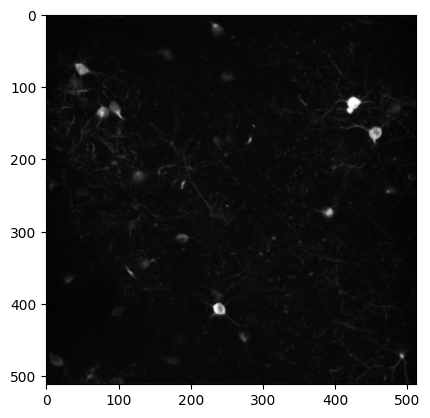

In [12]:
plt.imshow(ophys_experiment.max_projection, cmap='gray')

Max projection plots an average image from the movie recorded during an imaging session. Plotting max projection can give you a sense of how many neurons were visible during imaging and how clear and stable the imaging session was. 

#### load cell specimen table with cells' imaging metrics

In [13]:
ophys_experiment.cell_specimen_table.sample(3)

,cell_roi_id,height,mask_image_plane,max_correction_down,max_correction_left,max_correction_right,max_correction_up,valid_roi,width,x,y,roi_mask
cell_specimen_id,,,,,,,,,,,,
1086608294,1080722820,19,0,6.0,10.0,7.0,17.0,True,22,443,156,"[[False, False, False, False, False, False, Fa..."
1086608577,1080722882,19,0,6.0,10.0,7.0,17.0,True,21,471,121,"[[False, False, False, False, False, False, Fa..."
1086607903,1080722793,17,0,6.0,10.0,7.0,17.0,True,16,266,438,"[[False, False, False, False, False, False, Fa..."


```cell_specimen_table``` includes information about ```x``` and ```y``` coordinates of the cell in the imaging plane as well as how much correction was applied during motion correction process. 

```cell_roi_id``` is a unique id assigned to each ROI during segmentation.

```cell_specimen_id``` is a unique id assigned to each cell after cell matching, which means that if we were able to identify and match the same cell across multiple sessions, it can be identified by its unique cell specimen id.

```roi_mask``` is a boolean array that can be used to visualize where any given cell is in the imaging field. 

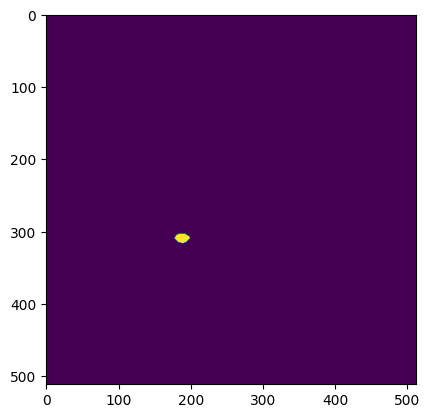

In [14]:
plt.imshow(ophys_experiment.cell_specimen_table.iloc[1]['roi_mask'])

#### show dff traces for the first 10 cells this experiment 

In [15]:
ophys_experiment.dff_traces.head(10)

,cell_roi_id,dff
cell_specimen_id,,
1086607071,1080722688,"[0.2915222644805908, 0.43415918946266174, 0.50..."
1086607143,1080722691,"[0.13391682505607605, 0.29041922092437744, 0.2..."
1086607340,1080722703,"[0.25876128673553467, 0.28472623229026794, 0.2..."
1086607562,1080722713,"[0.33256980776786804, 0.3811415135860443, 0.15..."
1086608432,1080722725,"[0.6332074403762817, 0.8515550494194031, 0.342..."
1086610383,1080722726,"[0.21246589720249176, 0.18863870203495026, 0.1..."
1086607814,1080722743,"[0.19181318581104279, 0.1326054036617279, 0.28..."
1086608913,1080722764,"[0.01678711175918579, 0.27544718980789185, 0.1..."
1086608195,1080722771,"[2.041205883026123, 0.9304129481315613, 0.6569..."


```dff_traces``` dataframe contains traces for all neurons in this experiment, unaligned to any events in the task.

You can select rows by their enumerated number using ```.iloc[]``` method:

In [16]:
ophys_experiment.dff_traces.iloc[4]

cell_roi_id                                           1080722725
dff            [0.6332074403762817, 0.8515550494194031, 0.342...
Name: 1086608432, dtype: object

Alternatively, you can use ```cell_specimen_id``` as index to select cells with ```.loc[]``` method:

In [17]:
ophys_experiment.dff_traces.loc[1086608577]

cell_roi_id                                           1080722882
dff            [0.20095007121562958, 0.1715908646583557, 0.16...
Name: 1086608577, dtype: object

If you don't want dff in a pandas dataframe format, you can load dff traces as an array, using ```np.vstack``` function to format the data into cell by time array and ```.values``` to only grab values in dff column:

In [18]:
dff_array = np.vstack(ophys_experiment.dff_traces.dff.values)
print('This array contrains dff traces from {} neurons and it is {} samples long.'.format(dff_array.shape[0], dff_array.shape[1]))

This array contrains dff traces from 23 neurons and it is 48284 samples long.


#### show events traces for the first 10 cells in this experiment

In [19]:
 ophys_experiment.events.head(10)

,cell_roi_id,events,filtered_events,lambda,noise_std
cell_specimen_id,,,,,
1086607071,1080722688,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.1599,0.124335
1086607143,1080722691,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0762,0.085989
1086607340,1080722703,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0832,0.089782
1086607562,1080722713,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0477,0.069837
1086608432,1080722725,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.1886,0.134772
1086610383,1080722726,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0431,0.064415
1086607814,1080722743,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0917,0.094015
1086608913,1080722764,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.1034,0.099846
1086608195,1080722771,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.9085,0.295720


```events``` table is similar to ```dff_traces``` but the output provides traces of extrapolated events. Events are computed on unmixed dff traces for each cell as described in [Giovannucci et al. 2019](https://pubmed.ncbi.nlm.nih.gov/30652683/). The magnitude of events approximates the firing rate of neurons with the resolusion of about 200 ms. The biggest advantage of using events over dff traces is they exclude prolonged Ca transients that may conteminate neural responses to subsequent stimuli. You can also use ```filtered_events``` which are events convolved with a filter created using ```stats.halfnorm``` method. 

```lambda``` is computed from Poisson distribution of events in the trace (think of it as a center of mass of the distribution, larger lambda == higher "firing rate").

```noise_std``` is a measure of variability in the events trace.

#### load ophys timestamps

The timestamps are the same for ```dff_traces``` and ```events```, in seconds

In [20]:
ophys_experiment.ophys_timestamps

array([   8.77128,    8.86448,    8.95768, ..., 4510.0275 , 4510.12074,
       4510.21397])

## Pick a cell and plot the traces

We can select a random cell from the experiment and plot its dff and events traces along with other behavioral and stimulus data.

In [21]:
cell_specimen_ids = ophys_experiment.cell_specimen_table.index.values # a list of all cell ids
cell_specimen_id = cell_specimen_ids[5] # let's pick 6th cell
print('Cell specimen id = {}'.format(cell_specimen_id)) # print id

Cell specimen id = 1086610383


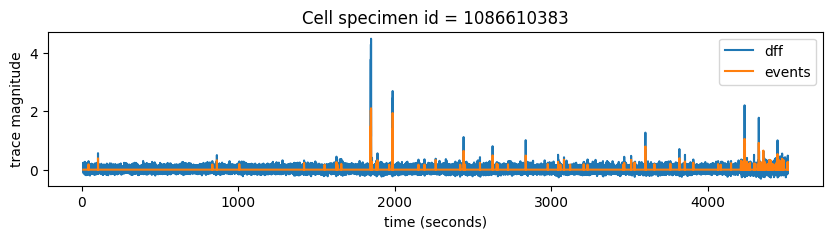

In [22]:
# plot dff and events traces overlaid from the cell selected above
fig, ax = plt.subplots(1,1, figsize = (10,2))
ax.plot(ophys_experiment.ophys_timestamps, ophys_experiment.dff_traces.loc[cell_specimen_id, 'dff'], label='dff')
ax.plot(ophys_experiment.ophys_timestamps, ophys_experiment.events.loc[cell_specimen_id, 'events'], label='events')
ax.set_xlabel('time (seconds)')
ax.set_ylabel('trace magnitude')
ax.set_title('Cell specimen id = {}'.format(cell_specimen_id))
ax.legend()


We can see that as expected, events trace is much cleaner than dff and it generally follows big Ca transients really well. We can also see that this cell was not very active during our experiment. Each experiment has a 5 minute movie at the end, which often drives neural activity really well. We can see a notable increase in cell's activity at the end of this experiment as well.

#### plot mouse running speed from this experiment

Text(0.5, 1.0, 'Ophys experiment 957759570')

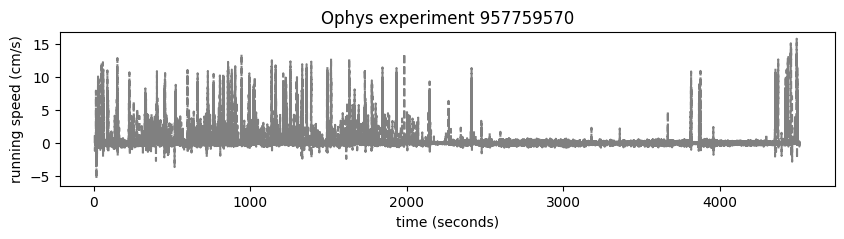

In [23]:

fig, ax = plt.subplots(1,1, figsize = (10,2))
ax.plot(ophys_experiment.stimulus_timestamps, ophys_experiment.running_speed['speed'], color='gray', linestyle='--')
ax.set_xlabel('time (seconds)')
ax.set_ylabel('running speed (cm/s)')
ax.set_title('Ophys experiment {}'.format(ophys_experiment_id))

#### plot pupil area for the same experiment

Text(0.5, 1.0, 'Ophys experiment 957759570')

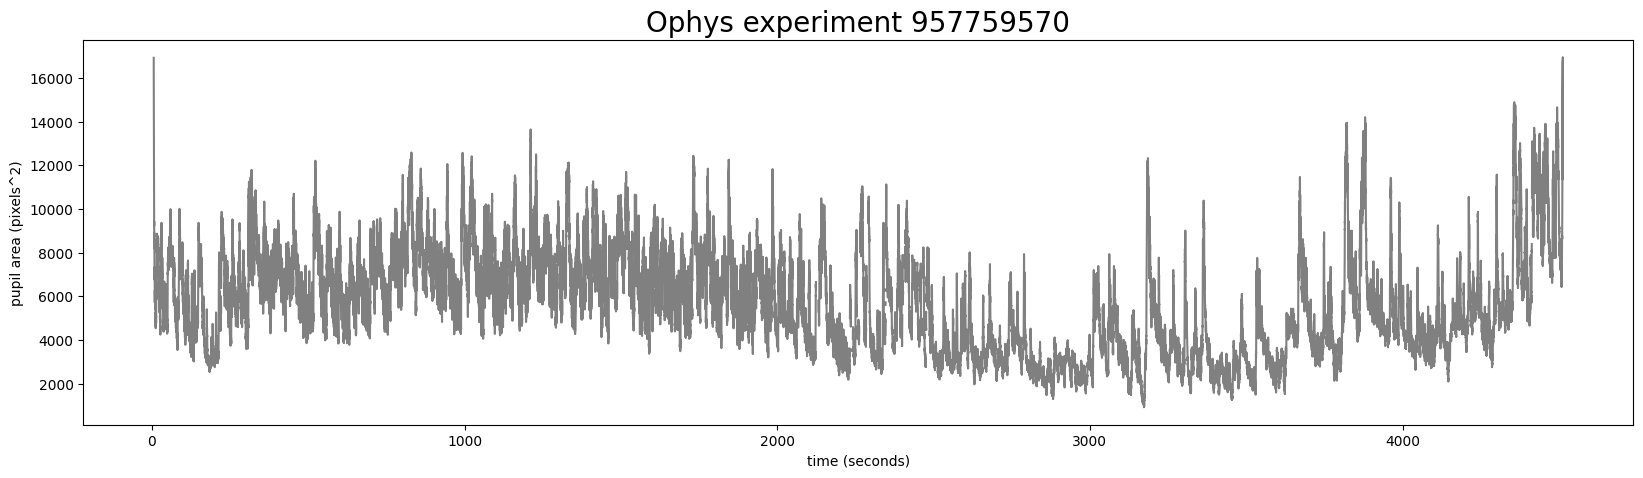

In [24]:

fig, ax = plt.subplots(1,1, figsize = (20,5))
ax.plot(ophys_experiment.eye_tracking.timestamps, ophys_experiment.eye_tracking.pupil_area, color='gray')
ax.set_xlabel('time (seconds)')
ax.set_ylabel('pupil area (pixels^2)')
ax.set_title('Ophys experiment {}'.format(ophys_experiment_id), fontsize = 20)

You can find all attributes and methods that belong to dataset class using this helpful method:

In [25]:
ophys_experiment.list_data_attributes_and_methods()

['average_projection',
 'behavior_session_id',
 'cell_specimen_table',
 'corrected_fluorescence_traces',
 'demixed_traces',
 'dff_traces',
 'events',
 'eye_tracking',
 'eye_tracking_rig_geometry',
 'get_cell_specimen_ids',
 'get_cell_specimen_indices',
 'get_dff_traces',
 'get_performance_metrics',
 'get_reward_rate',
 'get_rolling_performance_df',
 'get_segmentation_mask_image',
 'licks',
 'max_projection',
 'metadata',
 'motion_correction',
 'neuropil_traces',
 'ophys_experiment_id',
 'ophys_session_id',
 'ophys_timestamps',
 'raw_running_speed',
 'rewards',
 'roi_masks',
 'running_speed',
 'segmentation_mask_image',
 'stimulus_presentations',
 'stimulus_templates',
 'stimulus_timestamps',
 'task_parameters',
 'trials']

You can learn more about them by calling ```help``` on them: 

In [26]:
help(ophys_experiment.get_segmentation_mask_image)

Help on method get_segmentation_mask_image in module allensdk.brain_observatory.behavior.behavior_ophys_experiment:

get_segmentation_mask_image() -> allensdk.brain_observatory.behavior.image_api.Image method of allensdk.brain_observatory.behavior.behavior_ophys_experiment.BehaviorOphysExperiment instance
    a 2D binary image of all valid cell masks
    
    Returns
    ----------
    allensdk.brain_observatory.behavior.image_api.Image:
        array-like interface to segmentation_mask image data and
        metadata



## Get information about visual stimuli presented on each trial

get stimulus information for this experiment and assign it to a table called ```stimulus_table```

In [27]:
stimulus_table = ophys_experiment.stimulus_presentations
stimulus_table.head(10)

,duration,end_frame,flashes_since_change,image_index,image_name,is_change,omitted,start_frame,start_time,end_time
stimulus_presentations_id,,,,,,,,,,
0,0.25020,18001.0,0.0,0,im000,False,False,17986,308.75313,309.00333
1,0.25020,18046.0,1.0,0,im000,False,False,18031,309.50374,309.75394
2,0.25017,18091.0,2.0,0,im000,False,False,18076,310.25441,310.50458
3,0.25026,18136.0,3.0,0,im000,False,False,18121,311.00496,311.25522
4,0.25020,18181.0,4.0,0,im000,False,False,18166,311.75558,312.00578
5,0.25021,18226.0,5.0,0,im000,False,False,18211,312.50620,312.75641
6,0.25022,18271.0,6.0,0,im000,False,False,18256,313.25681,313.50703
7,0.25020,18316.0,0.0,6,im031,True,False,18301,314.00741,314.25761
8,0.25020,18361.0,1.0,6,im031,False,False,18346,314.75803,315.00823


This table provides helpful information like image name, start, duration and stop of image presentation, and whether the image was omitted. 

In [28]:
print('This experiment had {} stimuli.'.format(len(stimulus_table)))
print('Out of all stimuli presented, {} were omitted.'.format(len(stimulus_table[stimulus_table['image_name']=='omitted'])))


This experiment had 4797 stimuli.
Out of all stimuli presented, 160 were omitted.


You can also use ```keys()``` method to see the names of the columns in any pandas dataframe table:

In [29]:
stimulus_table.keys()

Index(['duration', 'end_frame', 'flashes_since_change', 'image_index',
       'image_name', 'is_change', 'omitted', 'start_frame', 'start_time',
       'end_time'],
      dtype='object')

## Get task and behavioral data for each trial

get behavioral trial information and assign it to ```trials_table```

In [30]:
trials_table = ophys_experiment.trials
trials_table.head(5)


,start_time,stop_time,lick_times,reward_time,reward_volume,hit,false_alarm,miss,is_change,aborted,...,catch,auto_rewarded,correct_reject,trial_length,response_time,change_frame,change_time,response_latency,initial_image_name,change_image_name
trials_id,,,,,,,,,,,,,,,,,,,,,
0,308.73646,309.85402,"[309.12011, 309.30359, 309.53711]",NaN,0.000,False,False,False,False,True,...,False,False,False,1.11756,NaN,NaN,NaN,NaN,im000,im000
1,310.23770,318.26089,"[314.37439, 314.50783, 314.64127, 314.79139, 3...",314.14086,0.005,False,False,False,True,False,...,False,True,False,8.02319,314.37439,18300.0,314.026728,0.347662,im000,im031
2,318.49442,319.37846,"[318.6779, 318.86138, 319.06156, 319.39515, 31...",NaN,0.000,False,False,False,False,True,...,False,False,False,0.88404,NaN,NaN,NaN,NaN,im031,im031
3,319.99565,323.19826,"[322.58109, 322.71452, 322.88134, 323.46514, 3...",NaN,0.000,False,False,False,False,True,...,False,False,False,3.20261,NaN,NaN,NaN,NaN,im031,im031
4,323.73205,331.02131,"[327.1515, 327.26826, 327.38503, 327.51846, 32...",326.91797,0.005,False,False,False,True,False,...,False,True,False,7.28926,327.15150,19065.0,326.787158,0.364342,im031,im000


In [31]:
trials_table.keys()

Index(['start_time', 'stop_time', 'lick_times', 'reward_time', 'reward_volume',
       'hit', 'false_alarm', 'miss', 'is_change', 'aborted', 'go', 'catch',
       'auto_rewarded', 'correct_reject', 'trial_length', 'response_time',
       'change_frame', 'change_time', 'response_latency', 'initial_image_name',
       'change_image_name'],
      dtype='object')

This table has information about experiment trials. ```go``` trials are change trials when the animal was supposed to lick. If the animal licked, ```hit``` is set to True for that trial. If the animal was rewarded, ```reward_time``` will have time in seconds. If this was an auto rewarded trial (regardless of whether the animal got it right), ```auto_rewarded``` is set to True. The trials table also includes ```response_latency``` which can be used as reaction time of the animal during the experiment.

## Plot an example of one selected cell

Now, we will put together a plotting functions that utilizes data in the dataset class to plot ophys traces and behavioral data from an experiment. 


In [32]:
# create a list of all unique stimuli presented in this experiment
unique_stimuli = [stimulus for stimulus in ophys_experiment.stimulus_presentations['image_name'].unique()]

# create a colormap with each unique image having its own color
colormap = {image_name: sns.color_palette()[image_number] for image_number, image_name in enumerate(np.sort(unique_stimuli))}
colormap['omitted'] = (1,1,1) # set omitted stimulus to white color

# add the colors for each image to the stimulus presentations table in the dataset
stimulus_presentations = ophys_experiment.stimulus_presentations
stimulus_presentations['color'] = ophys_experiment.stimulus_presentations['image_name'].map(lambda image_name: colormap[image_name])

In [33]:
# function to plot dff traces
def plot_dff_trace(ax, cell_specimen_id, initial_time, final_time):
    '''
        ax: axis on which to plot
        cell_specimen_id: id of the cell to plot
        intial_time: initial time to plot from
        final_time: final time to plot to
    '''
    #create a dataframe using dff trace from one seleted cell
    data = {'dff': ophys_experiment.dff_traces.loc[cell_specimen_id].dff,
        'timestamps': ophys_experiment.ophys_timestamps}
    df = pd.DataFrame(data)
    dff_trace_sample = df.query('timestamps >= @initial_time and timestamps <= @final_time')
    ax.plot(
        dff_trace_sample['timestamps'],
        dff_trace_sample['dff']/dff_trace_sample['dff'].max()
    )
    
# function to plot events traces    
def plot_events_trace(ax, cell_specimen_id, initial_time, final_time):
    # create a dataframe using events trace from one seleted cell
    data = {'events': ophys_experiment.events.loc[cell_specimen_id].events,
        'timestamps': ophys_experiment.ophys_timestamps}
    df = pd.DataFrame(data)
    events_trace_sample = df.query('timestamps >= @initial_time and timestamps <= @final_time')
    ax.plot(
        events_trace_sample['timestamps'],
        events_trace_sample['events']/events_trace_sample['events'].max()
    )
# function to plot running speed   
def plot_running(ax, initial_time, final_time):
    running_sample = ophys_experiment.running_speed.query('timestamps >= @initial_time and timestamps <= @final_time')
    ax.plot(
        running_sample['timestamps'],
        running_sample['speed']/running_sample['speed'].max(),
        '--',
        color = 'gray',
        linewidth = 1
    )
# function to plot pupil diameter   
def plot_pupil(ax, initial_time, final_time):
    pupil_sample = ophys_experiment.eye_tracking.query('timestamps >= @initial_time and timestamps <= @final_time')
    ax.plot(
        pupil_sample['timestamps'],
        pupil_sample['pupil_width']/pupil_sample['pupil_width'].max(),
        color = 'gray',
        linewidth = 1
    )
# function to plot licks
def plot_licks(ax, initial_time, final_time):
    licking_sample = ophys_experiment.licks.query('timestamps >= @initial_time and timestamps <= @final_time')
    ax.plot(
        licking_sample['timestamps'],
        np.zeros_like(licking_sample['timestamps']),
        marker = 'o',
        markersize = 3,
        color = 'black',
        linestyle = 'none'
    )
# function to plot rewards    
def plot_rewards(ax, initial_time, final_time):
    rewards_sample = ophys_experiment.rewards.query('timestamps >= @initial_time and timestamps <= @final_time')
    ax.plot(
        rewards_sample['timestamps'],
        np.zeros_like(rewards_sample['timestamps']),
        marker = 'd',
        color = 'blue',
        linestyle = 'none',
        markersize = 12,
        alpha = 0.5
    )
    
def plot_stimuli(ax, initial_time, final_time):
    stimulus_presentations_sample = stimulus_presentations.query('end_time >= @initial_time and start_time <= @final_time')
    for idx, stimulus in stimulus_presentations_sample.iterrows():
        ax.axvspan(stimulus['start_time'], stimulus['end_time'], color=stimulus['color'], alpha=0.25)

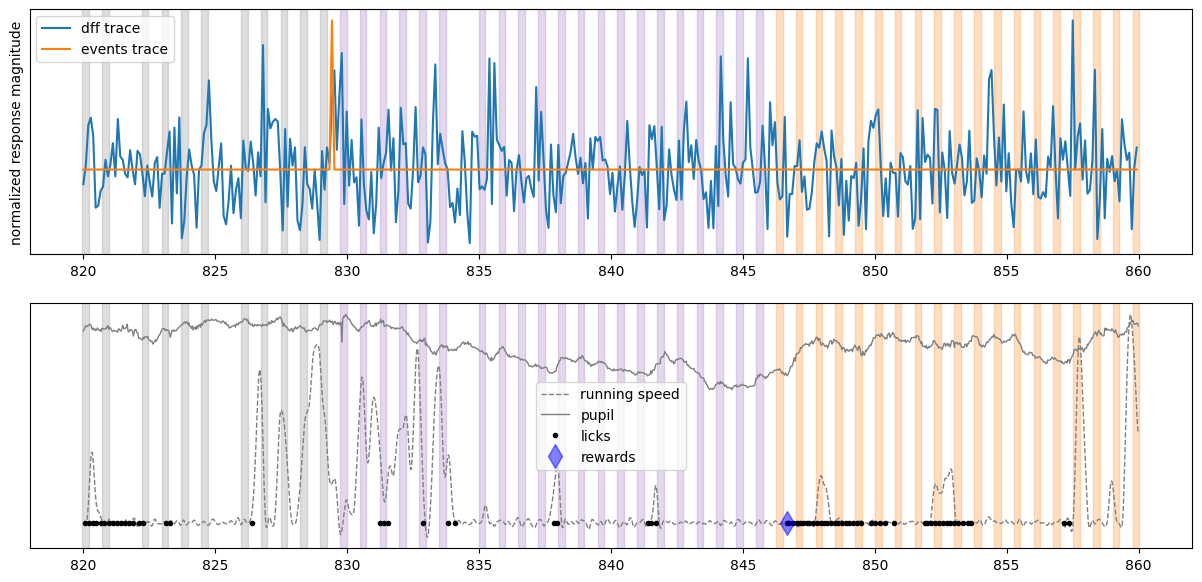

In [34]:
initial_time = 820 # start time in seconds
final_time = 860 # stop time in seconds
fig, ax = plt.subplots(2,1,figsize = (15,7))
plot_dff_trace(ax[0], cell_specimen_ids[3], initial_time, final_time)
plot_events_trace(ax[0], cell_specimen_ids[3], initial_time, final_time)
plot_stimuli(ax[0], initial_time, final_time)
ax[0].set_ylabel('normalized response magnitude')
ax[0].set_yticks([])
ax[0].legend(['dff trace', 'events trace'])

plot_running(ax[1], initial_time, final_time)
plot_pupil(ax[1], initial_time, final_time)
plot_licks(ax[1], initial_time, final_time)
plot_rewards(ax[1], initial_time, final_time)
plot_stimuli(ax[1], initial_time, final_time)

ax[1].set_yticks([])
ax[1].legend(['running speed', 'pupil','licks', 'rewards'])

From looking at the activity of this neuron, we can see that it was very active during our experiment but its activity does not appear to be reliably locked to image presentations. It does seem to vaguely follow animal's running speed, thus it might be modulated by running.

### Vip cell example

We can get a different, Vip experiment from *Ophys session 1* and plot it to compare response traces. This gives us a similar plot from a different inhibitory neuron to compare their neural dynamics.


In [35]:
# Select a Vip experiment with familiar images (session_number = 1, 2, or 3)
selected_experiment_table = ophys_experiment_table[(ophys_experiment_table.cre_line=='Vip-IRES-Cre')&
                        (ophys_experiment_table.session_number==1)]

# load the experiment data from the cache
ophys_experiment = cache.get_behavior_ophys_experiment(selected_experiment_table.index.values[1])
# get the cell IDs
cell_specimen_ids = ophys_experiment.cell_specimen_table.index.values # a list of all cell ids


/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [36]:

# create a list of all unique stimuli presented in this experiment
unique_stimuli = [stimulus for stimulus in ophys_experiment.stimulus_presentations['image_name'].unique()]

# create a colormap with each unique image having its own color
colormap = {image_name: sns.color_palette()[image_number] for image_number, image_name in enumerate(np.sort(unique_stimuli))}
colormap['omitted'] = (1,1,1)

# add the colors for each image to the stimulus presentations table in the dataset
ophys_experiment.stimulus_presentations['color'] = ophys_experiment.stimulus_presentations['image_name'].map(lambda image_name: colormap[image_name])

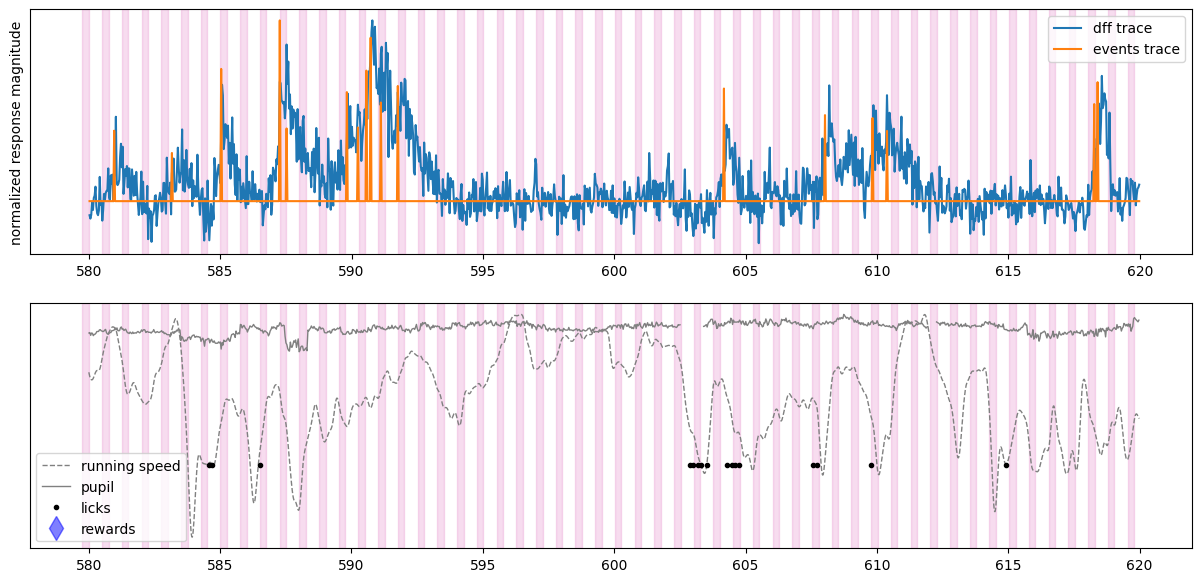

In [37]:
# we can plot the same information for a different cell in the dataset
initial_time = 580 # start time in seconds
final_time = 620 # stop time in seconds
fig, ax = plt.subplots(2,1,figsize = (15,7))

plot_dff_trace(ax[0], cell_specimen_ids[5], initial_time, final_time)
plot_events_trace(ax[0], cell_specimen_ids[5], initial_time, final_time)
plot_stimuli(ax[0], initial_time, final_time)
ax[0].set_ylabel('normalized response magnitude')
ax[0].set_yticks([])
ax[0].legend(['dff trace', 'events trace'])

plot_running(ax[1], initial_time, final_time)
plot_pupil(ax[1], initial_time, final_time)
plot_licks(ax[1], initial_time, final_time)
plot_rewards(ax[1], initial_time, final_time)
plot_stimuli(ax[1], initial_time, final_time)

ax[1].set_yticks([])
ax[1].legend(['running speed', 'pupil','licks', 'rewards'])

We can see that the dynamics of a Vip neuron are also not driven by the visual stimuli. Aligning neural activity to different behavioral or experimental events might reveal what this neuron is driven by.  